# Data Cleaning

In [1]:
import re
import glob
import pandas as pd
import numpy as np

In [2]:
def standardize_track(track):
    if isinstance(track, str):
        if (re.search('apps', track, re.IGNORECASE)):
            return 'Apps'
        elif (re.search('intro', track, re.IGNORECASE)):
            return 'Intro'
        elif (re.search('games', track, re.IGNORECASE)):
            return 'Games'
        elif (re.search('vr', track, re.IGNORECASE)):
            return 'VR'
    return track

## 2016

### Anon

In [3]:
files = glob.glob('../Datasets/SA Feedback Surveys_FINAL/2016/Anon *.csv')
datasets = { file: pd.read_csv(file) for file in files }

In [4]:
df_2016_anons = []

for dataset in datasets:
    name = dataset.split('/')[-1]
    
    name_split = name.split()
    df = datasets[dataset]
        
    # Fuzzy match rating columns
    overall_ratings = df.filter(like='overall').iloc[:,0]
    pacing_ratings = df.filter(like='pac').iloc[:,0]
    
    # Convert to numbers, drop nan, convert to int and double
    overall_ratings = pd.to_numeric(overall_ratings, errors='coerce').dropna().astype(int).apply(lambda x: x * 2)
    pacing_ratings = pd.to_numeric(pacing_ratings, errors='coerce').dropna().astype(int)
    
    loc_short2long = {
        'LA': 'Los Angeles',
        'NY': 'New York',
        'SF': 'San Francisco',
        'SG': 'Singapore',
        'SV': 'Sunnyvale',
        'HK': 'Hong Kong'
    }
    location = name_split[-1].split('.')[0]
    location = loc_short2long.get(location) or location
    
    df_week = pd.DataFrame({
        'Overall Rating': overall_ratings,
        'Pacing Rating': pacing_ratings,
        'Week': int(name_split[2]),
        'Location': location,
        'Year': 2016
    })
    df_2016_anons.append(df_week)

### Week 8

In [5]:
df_2016_week8 = pd.read_csv('../Datasets/SA Feedback Surveys_FINAL/2016/Week 8 Feedback (2016, incomplete) - results.csv')
df_2016_week8 = df_2016_week8.rename({
    'How likely is it that you would recommend the Make School Summer Academy to a friend?': 'Overall Rating',
    'location': 'Location',
    'track': 'Track'
}, axis=1)

df_2016_week8 = df_2016_week8[['Location', 'Track', 'Overall Rating']]

df_2016_week8['Track'] = df_2016_week8['Track'].map(standardize_track)
df_2016_week8['Week'] = 8
df_2016_week8['Year'] = 2016

df_2016_week8.head()

,Location,Track,Overall Rating,Week,Year
0,New York,Apps,10,8,2016
1,San Francisco,Intro,10,8,2016
2,New York,Intro,10,8,2016
3,Sunnyvale,Apps,9,8,2016
4,San Francisco,Intro,3,8,2016


## 2017

In [6]:
df_2017 = pd.read_csv('../Datasets/SA Feedback Surveys_FINAL/2017/Student Feedback Surveys-Superview.csv')

df_2017['Week'] = df_2017['Week'].apply(lambda x: int(x.split()[-1]))
df_2017['Track'] = df_2017['Track'].map(standardize_track)
df_2017['Overall Rating'] = pd.to_numeric(df_2017['Rating (Num)'], errors='coerce')
df_2017['Pacing Rating'] = df_2017['Schedule Pacing'].map({
    'Way too slow': 1,
    'A little too slow': 2,
    'Just right': 3,
    'A little too fast': 4,
    'Way too fast': 5
})
df_2017['Year'] = 2017

df_2017 = df_2017.drop(['ID', 'Rating (Num)', 'Schedule Pacing'], axis=1)

df_2017.head()

,Location,Track,Week,Overall Rating,Pacing Rating,Year
0,San Francisco,Apps,1,3.0,3.0,2017
1,Los Angeles,Apps,1,4.0,4.0,2017
2,San Francisco,Games,1,4.0,1.0,2017
3,NaN,NaN,2,4.0,4.0,2017
4,New York City,Apps,1,4.0,3.0,2017


## Combined

In [7]:
df = pd.concat([df_2016_week8, *df_2016_anons, df_2017], sort=False)
df['Location'] = df['Location'].str.replace(' City', '')
def convert_to_nps(rating):
    if rating >= 9:
        return 1
    elif rating >= 7:
        return 0
    elif rating >= 1:
        return -1
    else:
        return np.nan
df['Overall NPS'] = df['Overall Rating'].map(convert_to_nps)
df['Pacing NPS'] = df['Pacing Rating'].map({1: -1, 2: 0, 3: 1, 4: 0, 5: -1})
df.head()

,Location,Track,Overall Rating,Week,Year,Pacing Rating,Overall NPS,Pacing NPS
0,New York,Apps,10.0,8,2016,NaN,1.0,NaN
1,San Francisco,Intro,10.0,8,2016,NaN,1.0,NaN
2,New York,Intro,10.0,8,2016,NaN,1.0,NaN
3,Sunnyvale,Apps,9.0,8,2016,NaN,1.0,NaN
4,San Francisco,Intro,3.0,8,2016,NaN,-1.0,NaN


# Analysis

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

## What is the NPS score of each track by city?

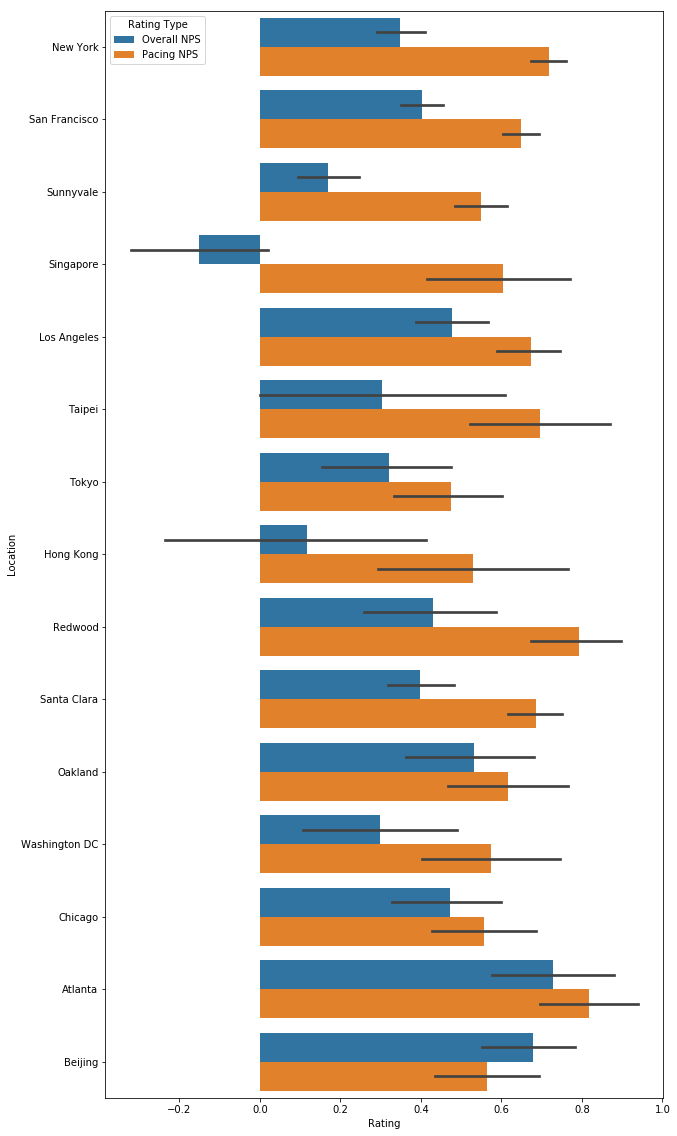

In [9]:
plt.figure(figsize=(10,20))
data = pd.melt(df, id_vars=['Location', 'Track'],
               value_vars=['Overall NPS', 'Pacing NPS'],
              value_name='Rating', var_name='Rating Type')
sns.barplot(x='Rating', hue='Rating Type', y='Location', data=data)

## What is the trend of the Overall NPS score over time?

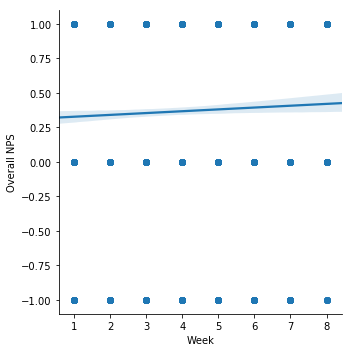

In [10]:
sns.lmplot(x='Week', y='Overall NPS', data=df)

## What is the popularity of each track by city?

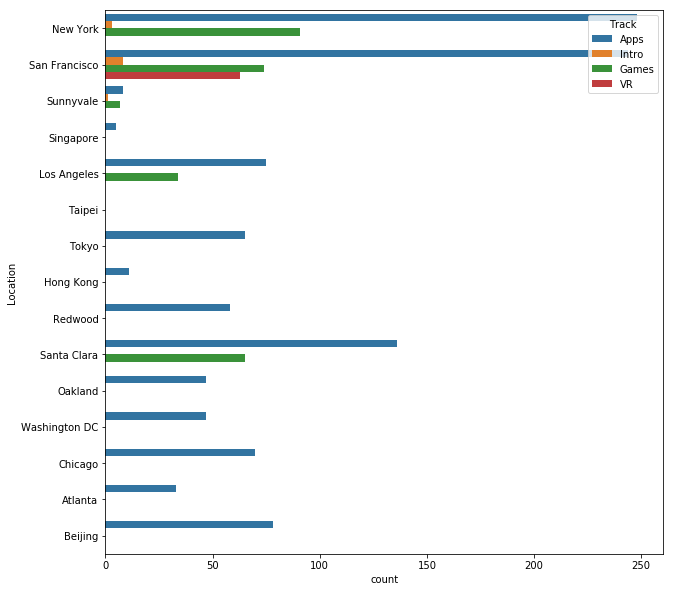

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location', hue='Track', data=df)

## How does feedback engagement change over time?

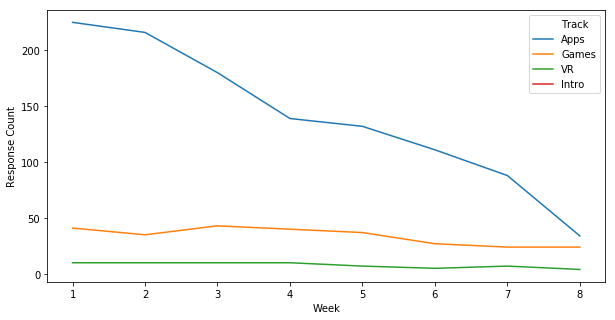

In [12]:
data = df.groupby(['Week', 'Track']).size().reset_index()
data = data.rename(columns={0: 'Response Count'})
plt.figure(figsize=(10,5))
sns.lineplot(hue='Track', x='Week', y='Response Count', data=data)

# What is the relationship between class size and Overall NPS

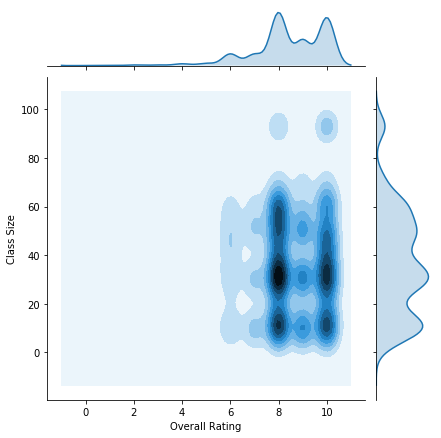

In [48]:
size = df.groupby(['Location', 'Year', 'Week'])['Week'].transform('count').to_numpy()
overall = df['Overall Rating'].to_numpy()
sns.jointplot(overall, size, kind='kde').set_axis_labels('Overall Rating', 'Class Size')

# Potential Improvements
## Current
- More consistent data
- Clear meanings to fields
- Location standardization
- More data

## Future
- Outcomes tracking?